## Overview:
In this project, we will be focusing on feature-based time series analysis, where the sequential data is converted to tabular data before processing.

[1] Ben D Fulcher. “Feature-based time-series analysis”. In: Feature engineering
for machine learning and data analytics. CRC press, 2018, pp. 87–116.

[2] Ben D Fulcher and Nick S Jones. “Highly comparative feature-based timeseries
classification”. In: IEEE Transactions on Knowledge and Data Engineering
26.12 (2014), pp. 3026–3037.

1. Labelling - Extract label from training data set
2. EDA - Exploratory Data Analysis
3. Preprocessing - Denoising , normalization etc..
4. Feature Engineering - Feature Extraction and Feature Selection use auto feature engineering tools TSFresh to generate feature and next prune the redundant and irrelavant features
5. Predictive Modelling 

## Understanding the problem
- <b>Background Information</b>: Refer to publications by Saxena, Goebel, Simon, Eklund, Richter, Wang, Frederick, and Abbas for detailed information on turbofan engines, C-MAPSS datasets, and simulated system decomposition.
- <b>Dataset Complexity</b>: Datasets #1 to #4 increase in complexity, so it's recommended to start with #1 and gradually progress.
- <b>Challenge Datasets</b>: These datasets are mid-level in complexity and lack ground truth for immediate feedback. They can be used for validation and comparison.

#### Aircraft turbofan engine and its degredation
Aircraft turbofan engine like any other machinery faces degradation over the course of their lifetime, which affects their performance and reliability. 
This leads to questions of weather we will be able to predict their degredation and eventual machine failure ahead of time with the measure of RUL(remaining usable life) based on the whole lifecycle data collected from machines.
If we can predict this information, then we will be able to plan its maintainence, ensure its operations and hence improving cost savings and safety.

The C-MAPSS (Commercial Modular Aero-Propulsion System Simulation) dataset is a collection of simulated turbofan engine data generated to support research in prognostics and health management (PHM). It provides a realistic and controlled environment for developing and evaluating algorithms for predicting the Remaining Useful Life (RUL) of complex systems.



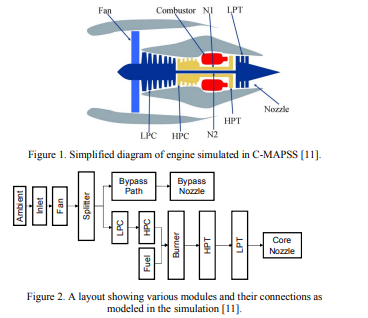

In [4]:
from IPython.display import Image

Image("turbofan.png")

## Data
- Datasets #1 through #4 increase in complexity and provide ground truth for performance evaluation.
Dataset Usage: Dataset #1 was the most used. apparent simplicity and monotonic sensor trends 
- Model before generalization: direct comparisons between results from these datasets may not always be appropriate due to their varying levels of complexity and the absence of ground truth in some cases. 
- Model Generalization: A universal generalized model that can handle all levels of complexity would be necessary for accurate comparisons.


Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to: 1) unit number 2) time, in cycles 3) operational setting 1 4) operational setting 2 5) operational setting 3 6) sensor measurement 1 7) sensor measurement 2 ... 26) sensor measurement 26

here provided 3 types of data in the form of text. i.e. train data, test data, RUL data.

Here's how the different datasets are typically used:

- `Training dataset`: Used to train the prognostic model. It contains sensor data and corresponding RUL values for a subset of units.
- `Testing dataset`: Used to evaluate the performance of the trained model. It contains sensor data for a different subset of units, and the RUL values are withheld for comparison with the model's predictions.
- `RUL dataset`: Provides the actual RUL values for the testing dataset, allowing you to compare the model's predicted RUL with the true RUL.

In [5]:
import pandas as pd

train = "train_FD001.txt"
test="test_FD001.txt"
RUL = "RUL_FD001.txt"
train_df = pd.read_csv(train,sep=" ",header=None)
test_df = pd.read_csv(test, sep=" ", header=None)
RUL_df = pd.read_csv(RUL, sep=" ", header=None)

print(train_df.shape)
print(test_df.shape)
print(RUL_df.shape)

(20631, 28)
(13096, 28)
(100, 2)


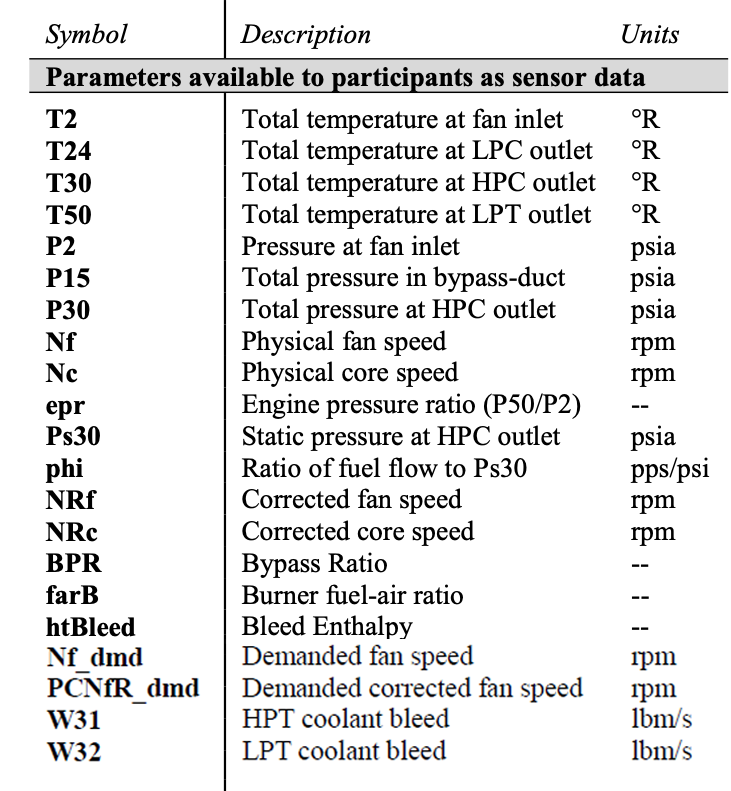

In [6]:
Image("data-columns.png")

In [7]:
columns = [
    "unit_ID",
    "cycles",
    "setting_1",
    "setting_2",
    "setting_3",
    "T2",
    "T24",
    "T30",
    "T50",
    "P2",
    "P15",
    "P30",
    "Nf",
    "Nc",
    "epr",
    "Ps30",
    "phi",
    "NRf",
    "NRc",
    "BPR",
    "farB",
    "htBleed",
    "Nf_dmd",
    "PCNfR_dmd",
    "W31",
    "W32",
]


In [8]:
train_df
train_df.dropna(axis=1, inplace=True) # Drop columns with Nan data
train_df.columns=columns
train_df

,unit_ID,cycles,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


#### Finding the Remaining Useful Life (RUL) from the Training Data:
 In the CMAPSS training dataset, the cycle column represents the operational time or cycle number for each engine unit. Each row in the dataset corresponds to one cycle of operation for a particular engine unit. The cycle starts from 1 and increments by 1 for each subsequent time step until the engine fails.

To calculate the Remaining Useful Life (RUL) for each cycle in the training dataset:

1. Determine the Maximum Cycle for Each Engine Unit:

- The maximum cycle number for each engine unit represents the point just before the engine fails (i.e., the last recorded cycle).

2. Calculate RUL for Each Cycle:

- The RUL at any given cycle for an engine unit is the difference between the maximum cycle number and the current cycle number.

In [18]:
train_df["max_cycle"] = train_df.groupby("unit_ID")["cycles"].transform("max")
train_df["RUL"] = train_df["max_cycle"] - train_df["cycles"]

train_df_cycles = (
    train_df[["unit_ID", "cycles"]]
    .groupby("unit_ID")
    .max()
    # .sort_values(by="cycles", ascending=False)
)
train_df_cycles = pd.DataFrame(train_df_cycles)
train_df
train_df_cycles

,cycles
unit_ID,
1,192
2,287
3,179
4,189
5,269
...,...
96,336
97,202
98,156


C:\Users\zihan\AppData\Local\Temp\ipykernel_47792\1278003842.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


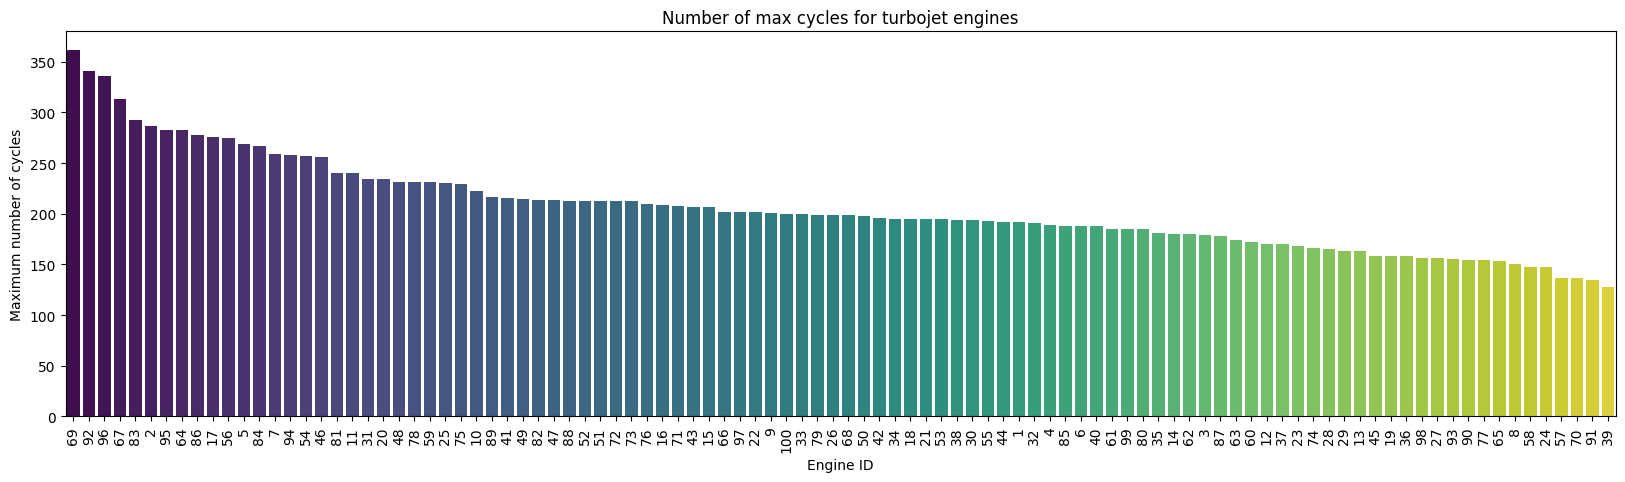

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))

sns.barplot(
    x=train_df_cycles.index,
    y="cycles",
    data=train_df_cycles,
    palette="viridis",
    # orient="h",
    order=train_df_cycles.sort_values(by="cycles", ascending=False).index,
)
plt.xticks(rotation=90)
plt.title('Number of max cycles for turbojet engines')
plt.xlabel('Engine ID')
plt.ylabel('Maximum number of cycles')
plt.show()

In [11]:
test_df
test_df.dropna(axis=1, inplace=True)  # Drop columns with Nan data
test_df.columns = columns
test_df

,unit_ID,cycles,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [12]:
RUL_df
RUL_df["unit_ID"] = pd.Series(range(1, 101))
RUL_df.dropna(axis=1, inplace=True)  # Drop columns with Nan data'
RUL_df.rename(columns={0:'RUL'},inplace=True)
reorder = ["unit_ID" ,"RUL"]
RUL_df=RUL_df.reindex(columns=reorder)
RUL_df

,unit_ID,RUL
0,1,112
1,2,98
2,3,69
3,4,82
4,5,91
...,...,...
95,96,137
96,97,82
97,98,59
98,99,117


### Exploratory Data Analysis
The first step is to perform exploratory data analysis (EDA). You are encouraged
to use your creative ways to display as well as show the analysis.
- An option to display sample time series data and explore visual cues such as trend, cycles, etc.
- An option to display the statistics such as mean, variance. These statistics should help guide the designer in manual removal of irrelevant/ redundant features.

##### Understanding relationship of turbojet to each machine parameter

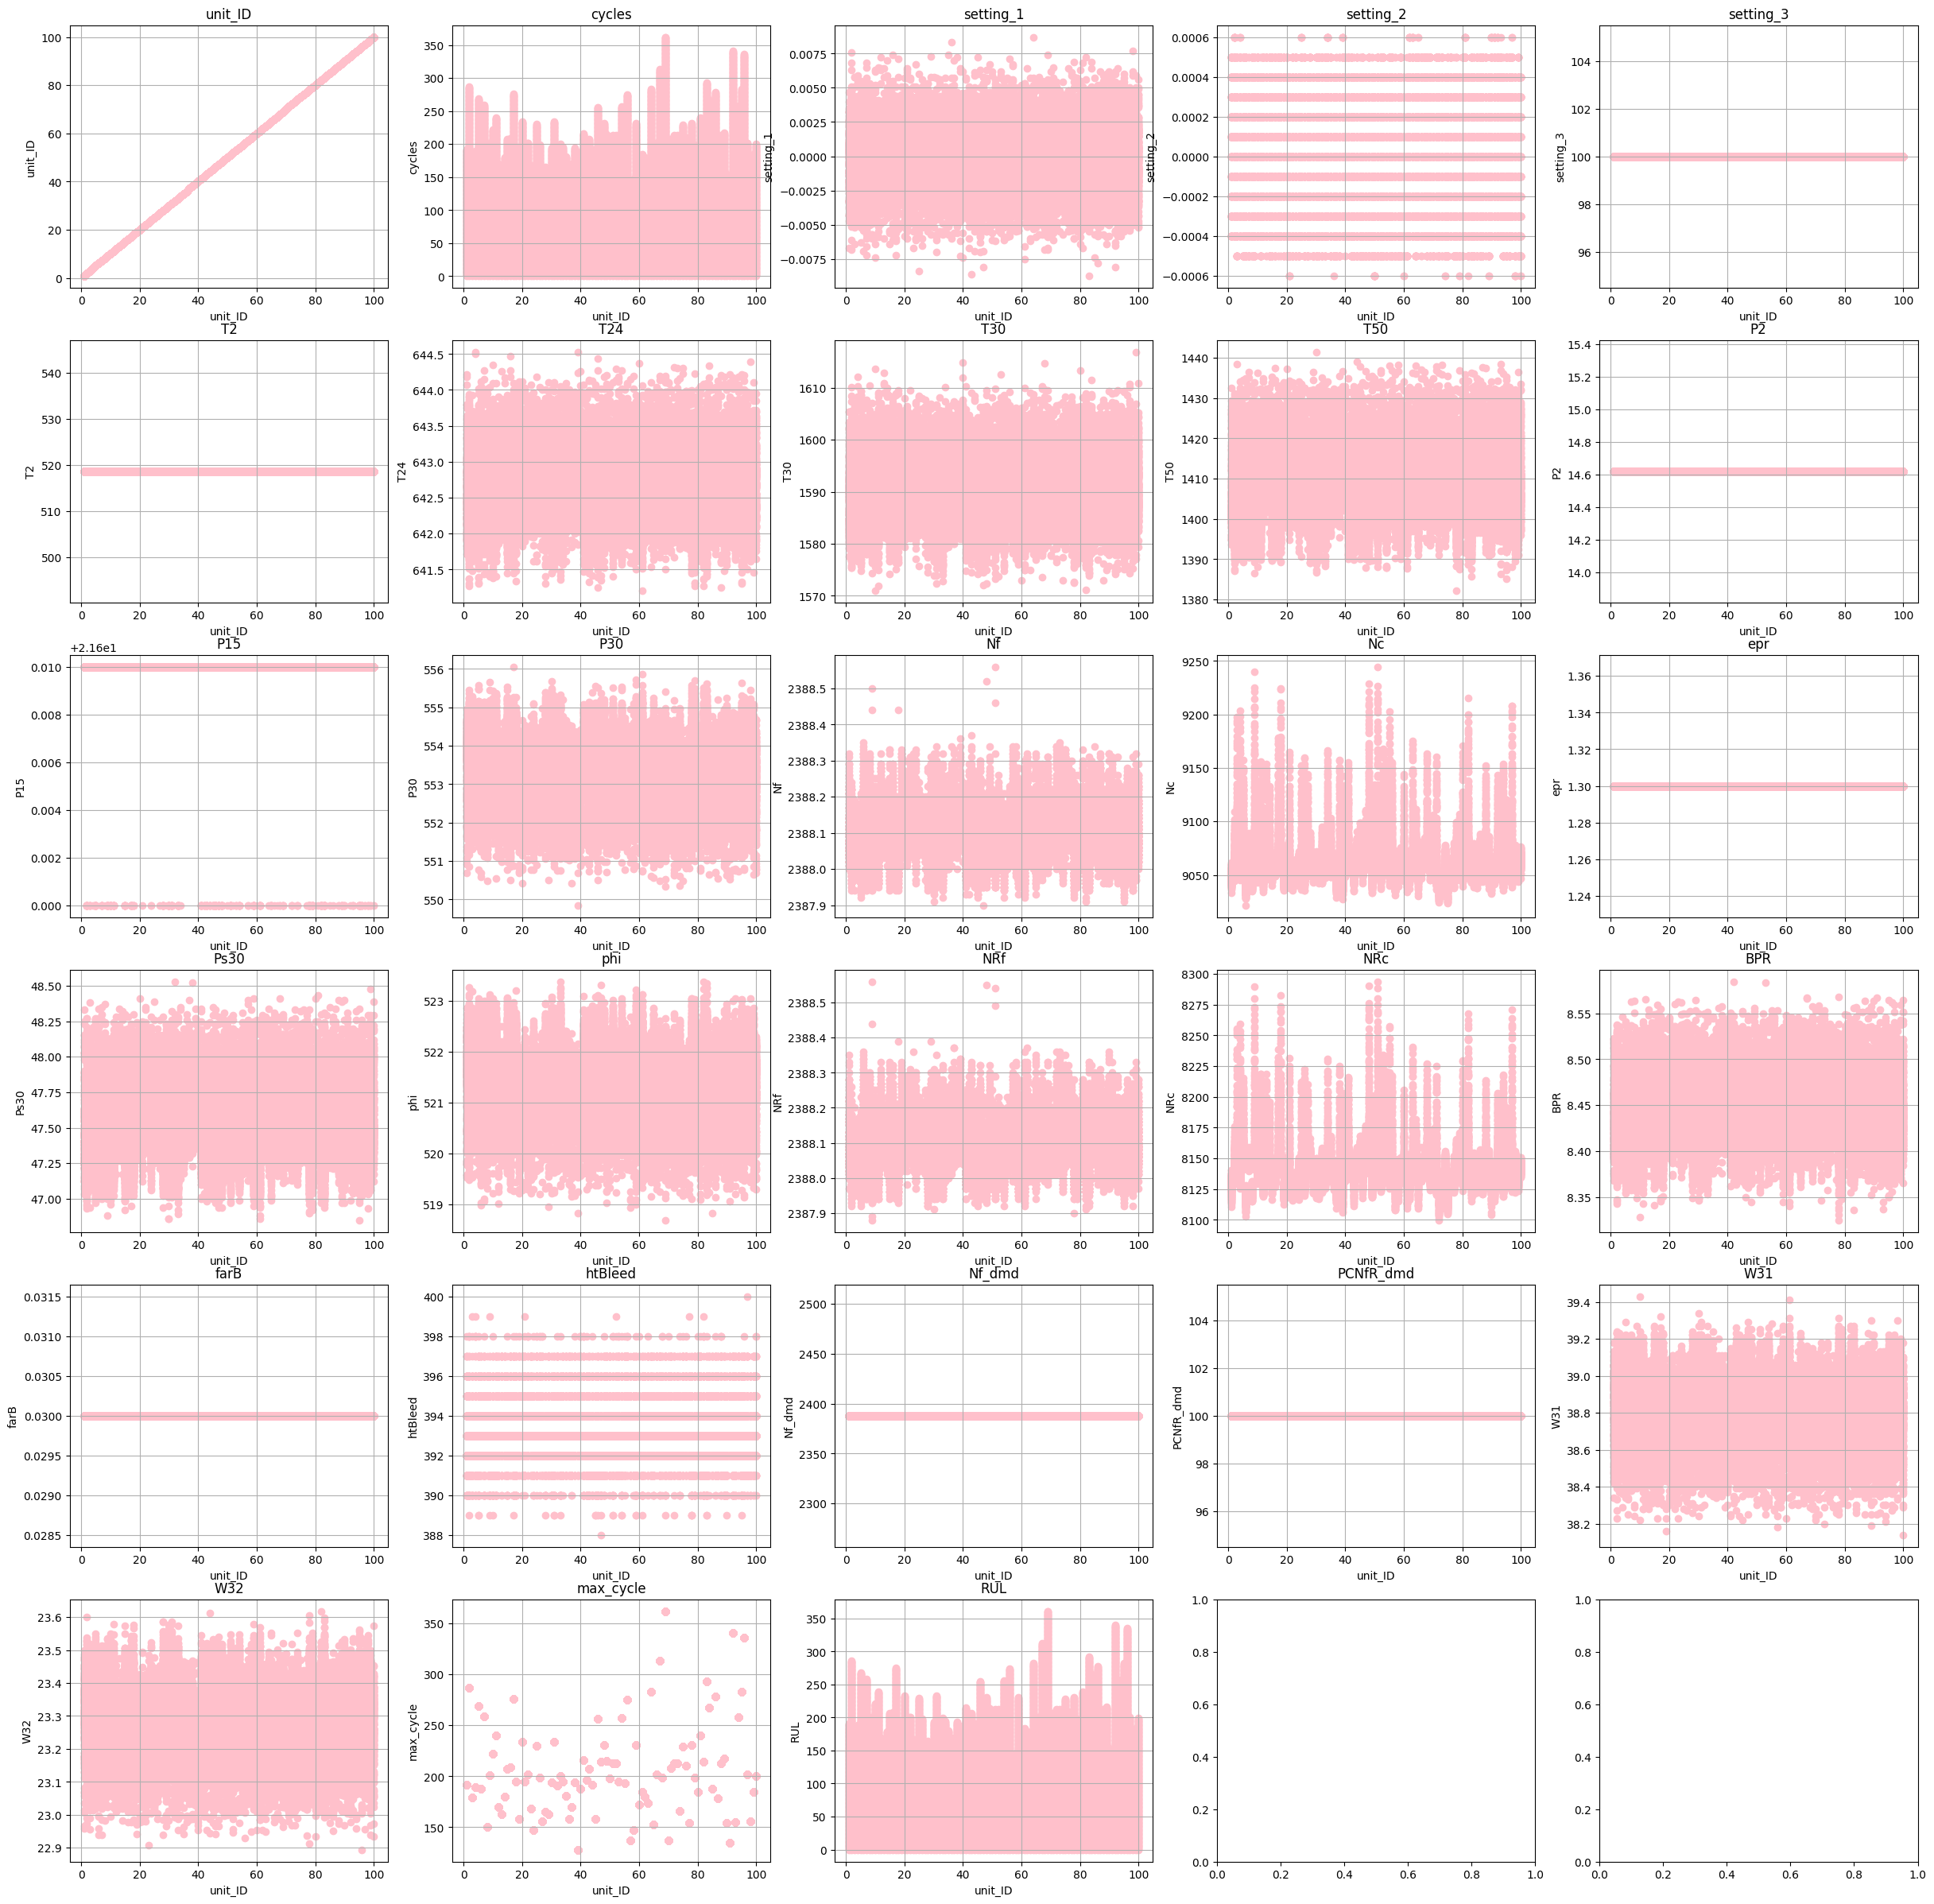

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(6, 5, figsize=(30, 30))
ax = ax.flatten()

for i in range(len(train_df.columns)):
    ax[i].scatter(train_df['unit_ID'],train_df.iloc[:,i],color='pink') # scatterplot of each columns, using all rows against 'unit_ID'
    ax[i].set_title(train_df.columns[i])
    ax[i].set_ylabel(train_df.columns[i])
    ax[i].set_xlabel("unit_ID")
    ax[i].grid()

plt.show()

##### Understanding relationship of cycles(to failure) to each machine parameter

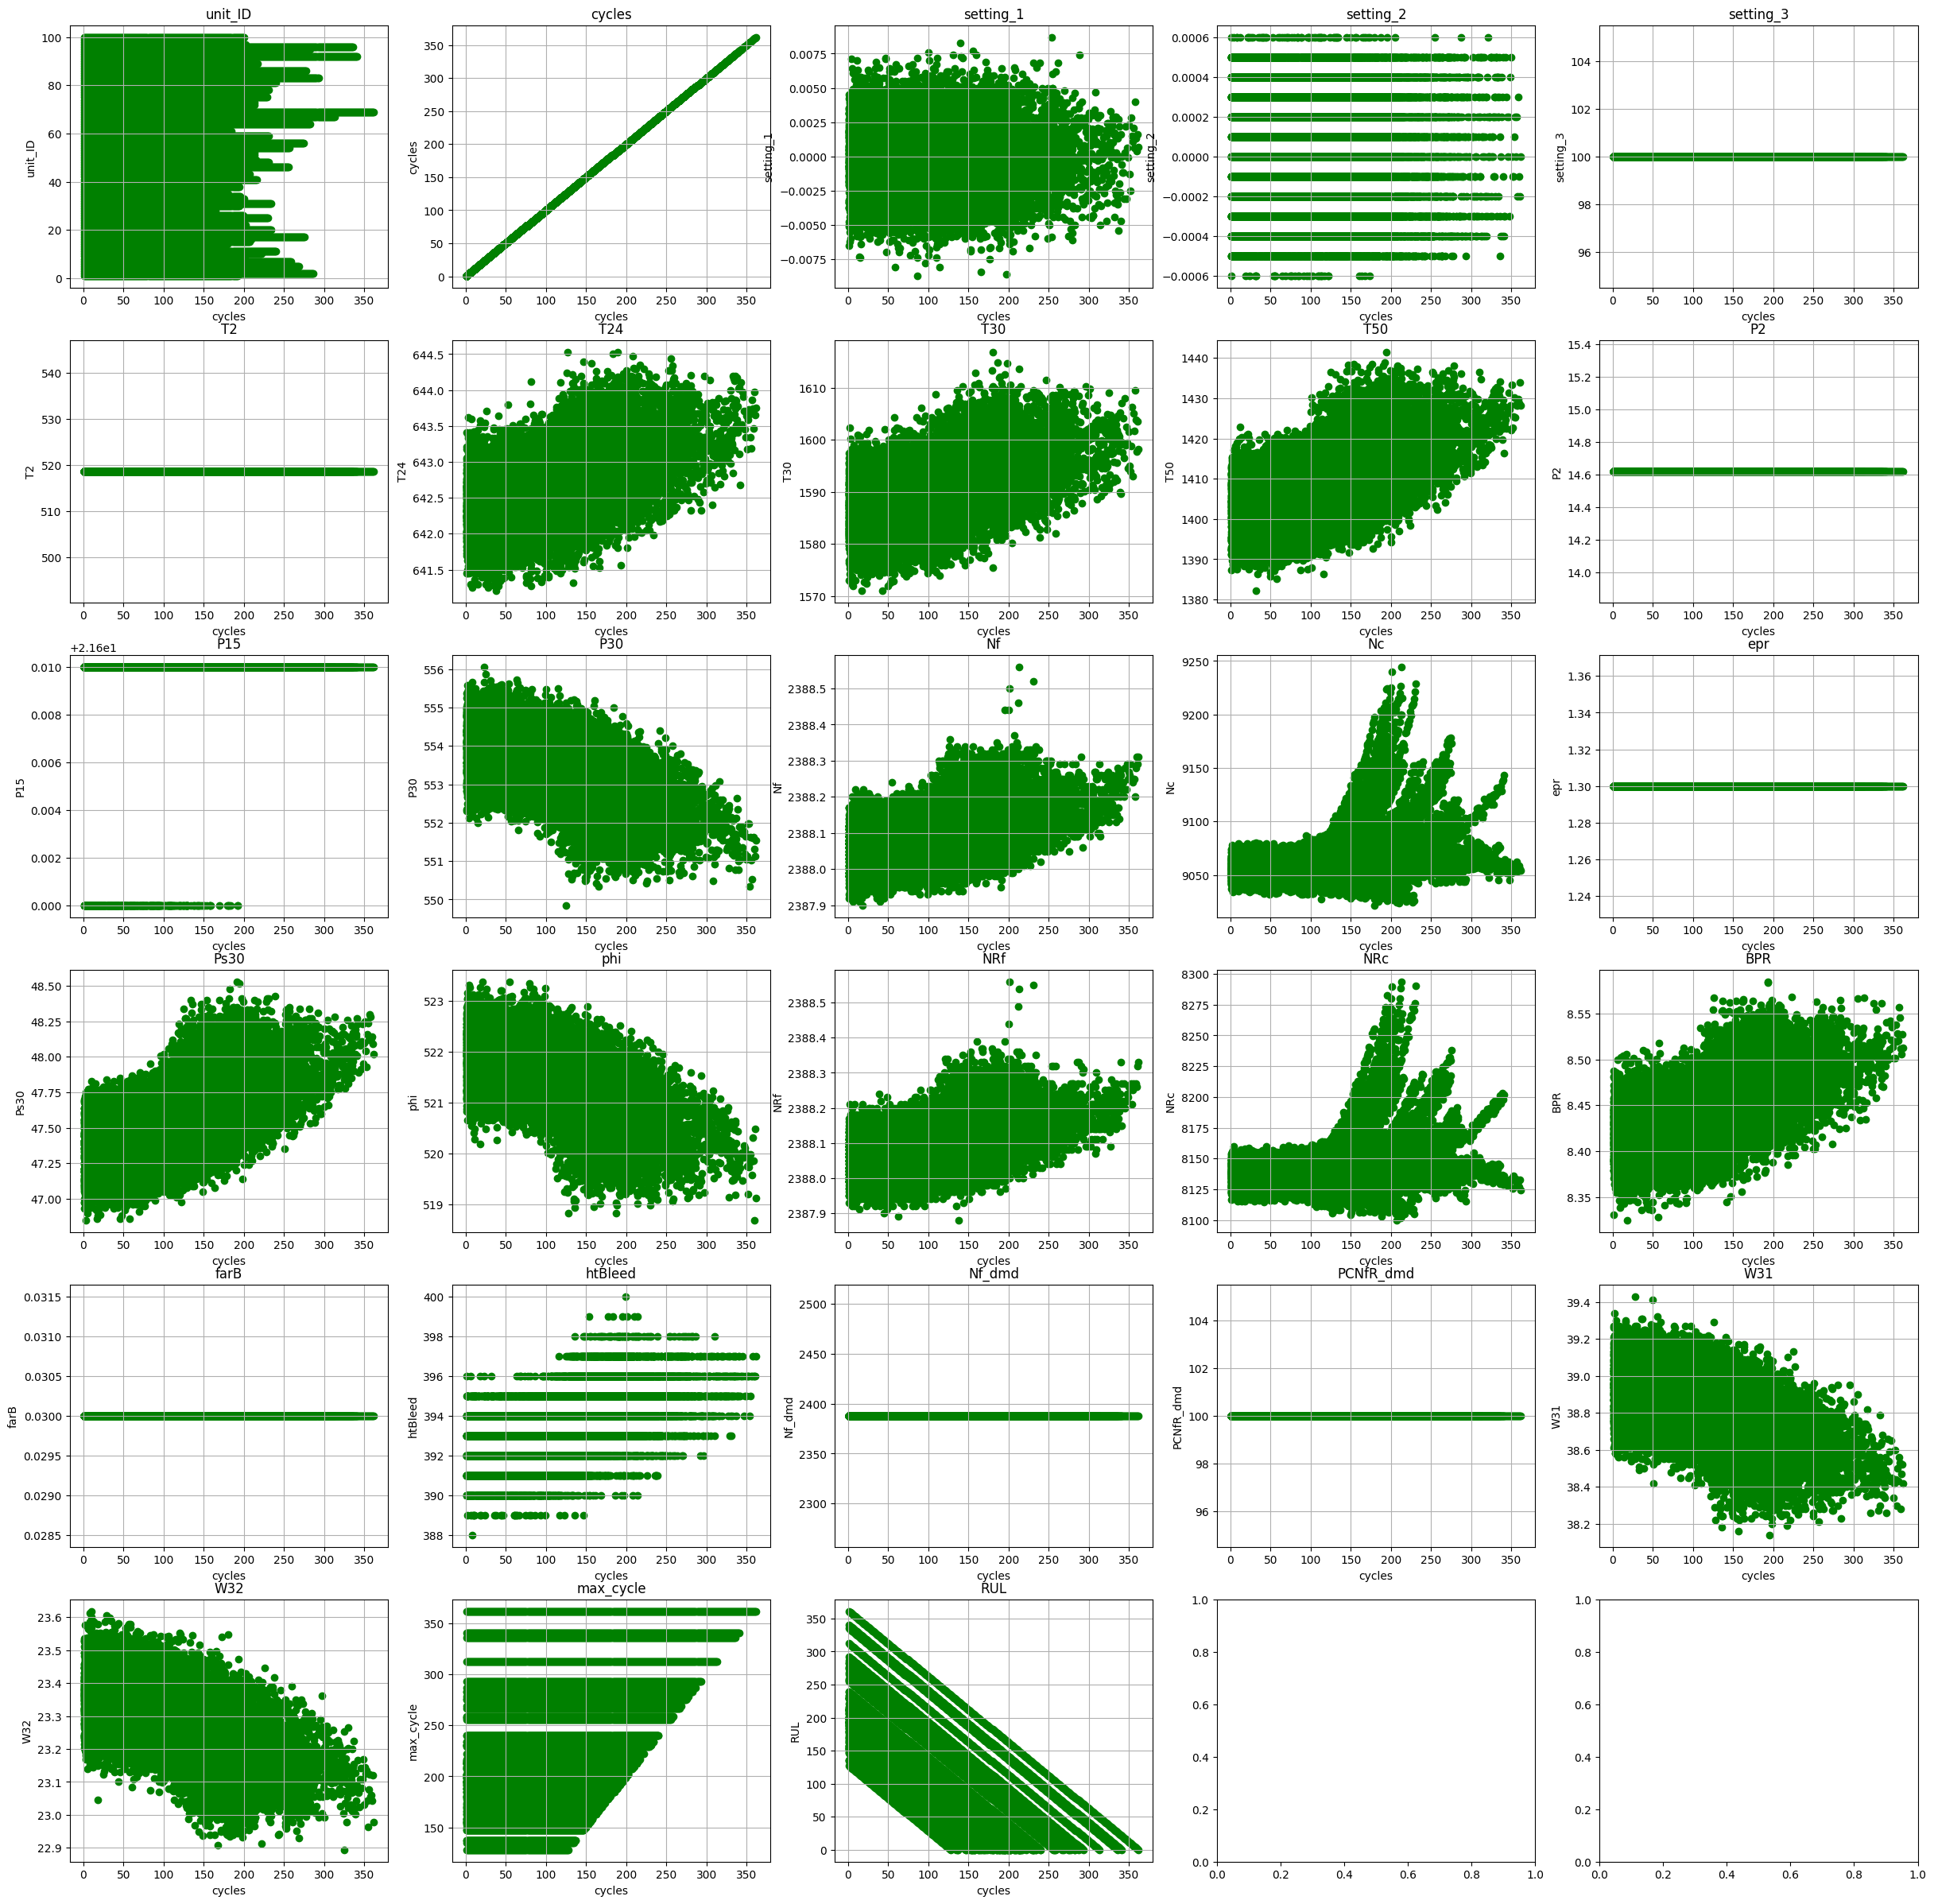

In [14]:
fig, ax = plt.subplots(6, 5, figsize=(30, 30))
ax = ax.flatten()

for i in range(len(train_df.columns)):
    ax[i].scatter(
        train_df["cycles"], train_df.iloc[:, i], color="green"
    )  # scatterplot of each columns, using all rows against 'cycles'
    ax[i].set_title(train_df.columns[i])
    ax[i].set_ylabel(train_df.columns[i])
    ax[i].set_xlabel("cycles")
    ax[i].grid()

plt.show()

##### Understanding the distribution density of all machine parameters and features

C:\Users\zihan\AppData\Local\Temp\ipykernel_47792\110729471.py:17: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(train_df.iloc[:, i], ax=ax[i], label="KDE", color="red")
C:\Users\zihan\AppData\Local\Temp\ipykernel_47792\110729471.py:17: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(train_df.iloc[:, i], ax=ax[i], label="KDE", color="red")
C:\Users\zihan\AppData\Local\Temp\ipykernel_47792\110729471.py:17: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(train_df.iloc[:, i], ax=ax[i], label="KDE", color="red")
C:\Users\zihan\AppData\Local\Temp\ipykernel_47792\110729471.py:17: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(train_df.iloc[:, i], ax=ax[i], label="KDE

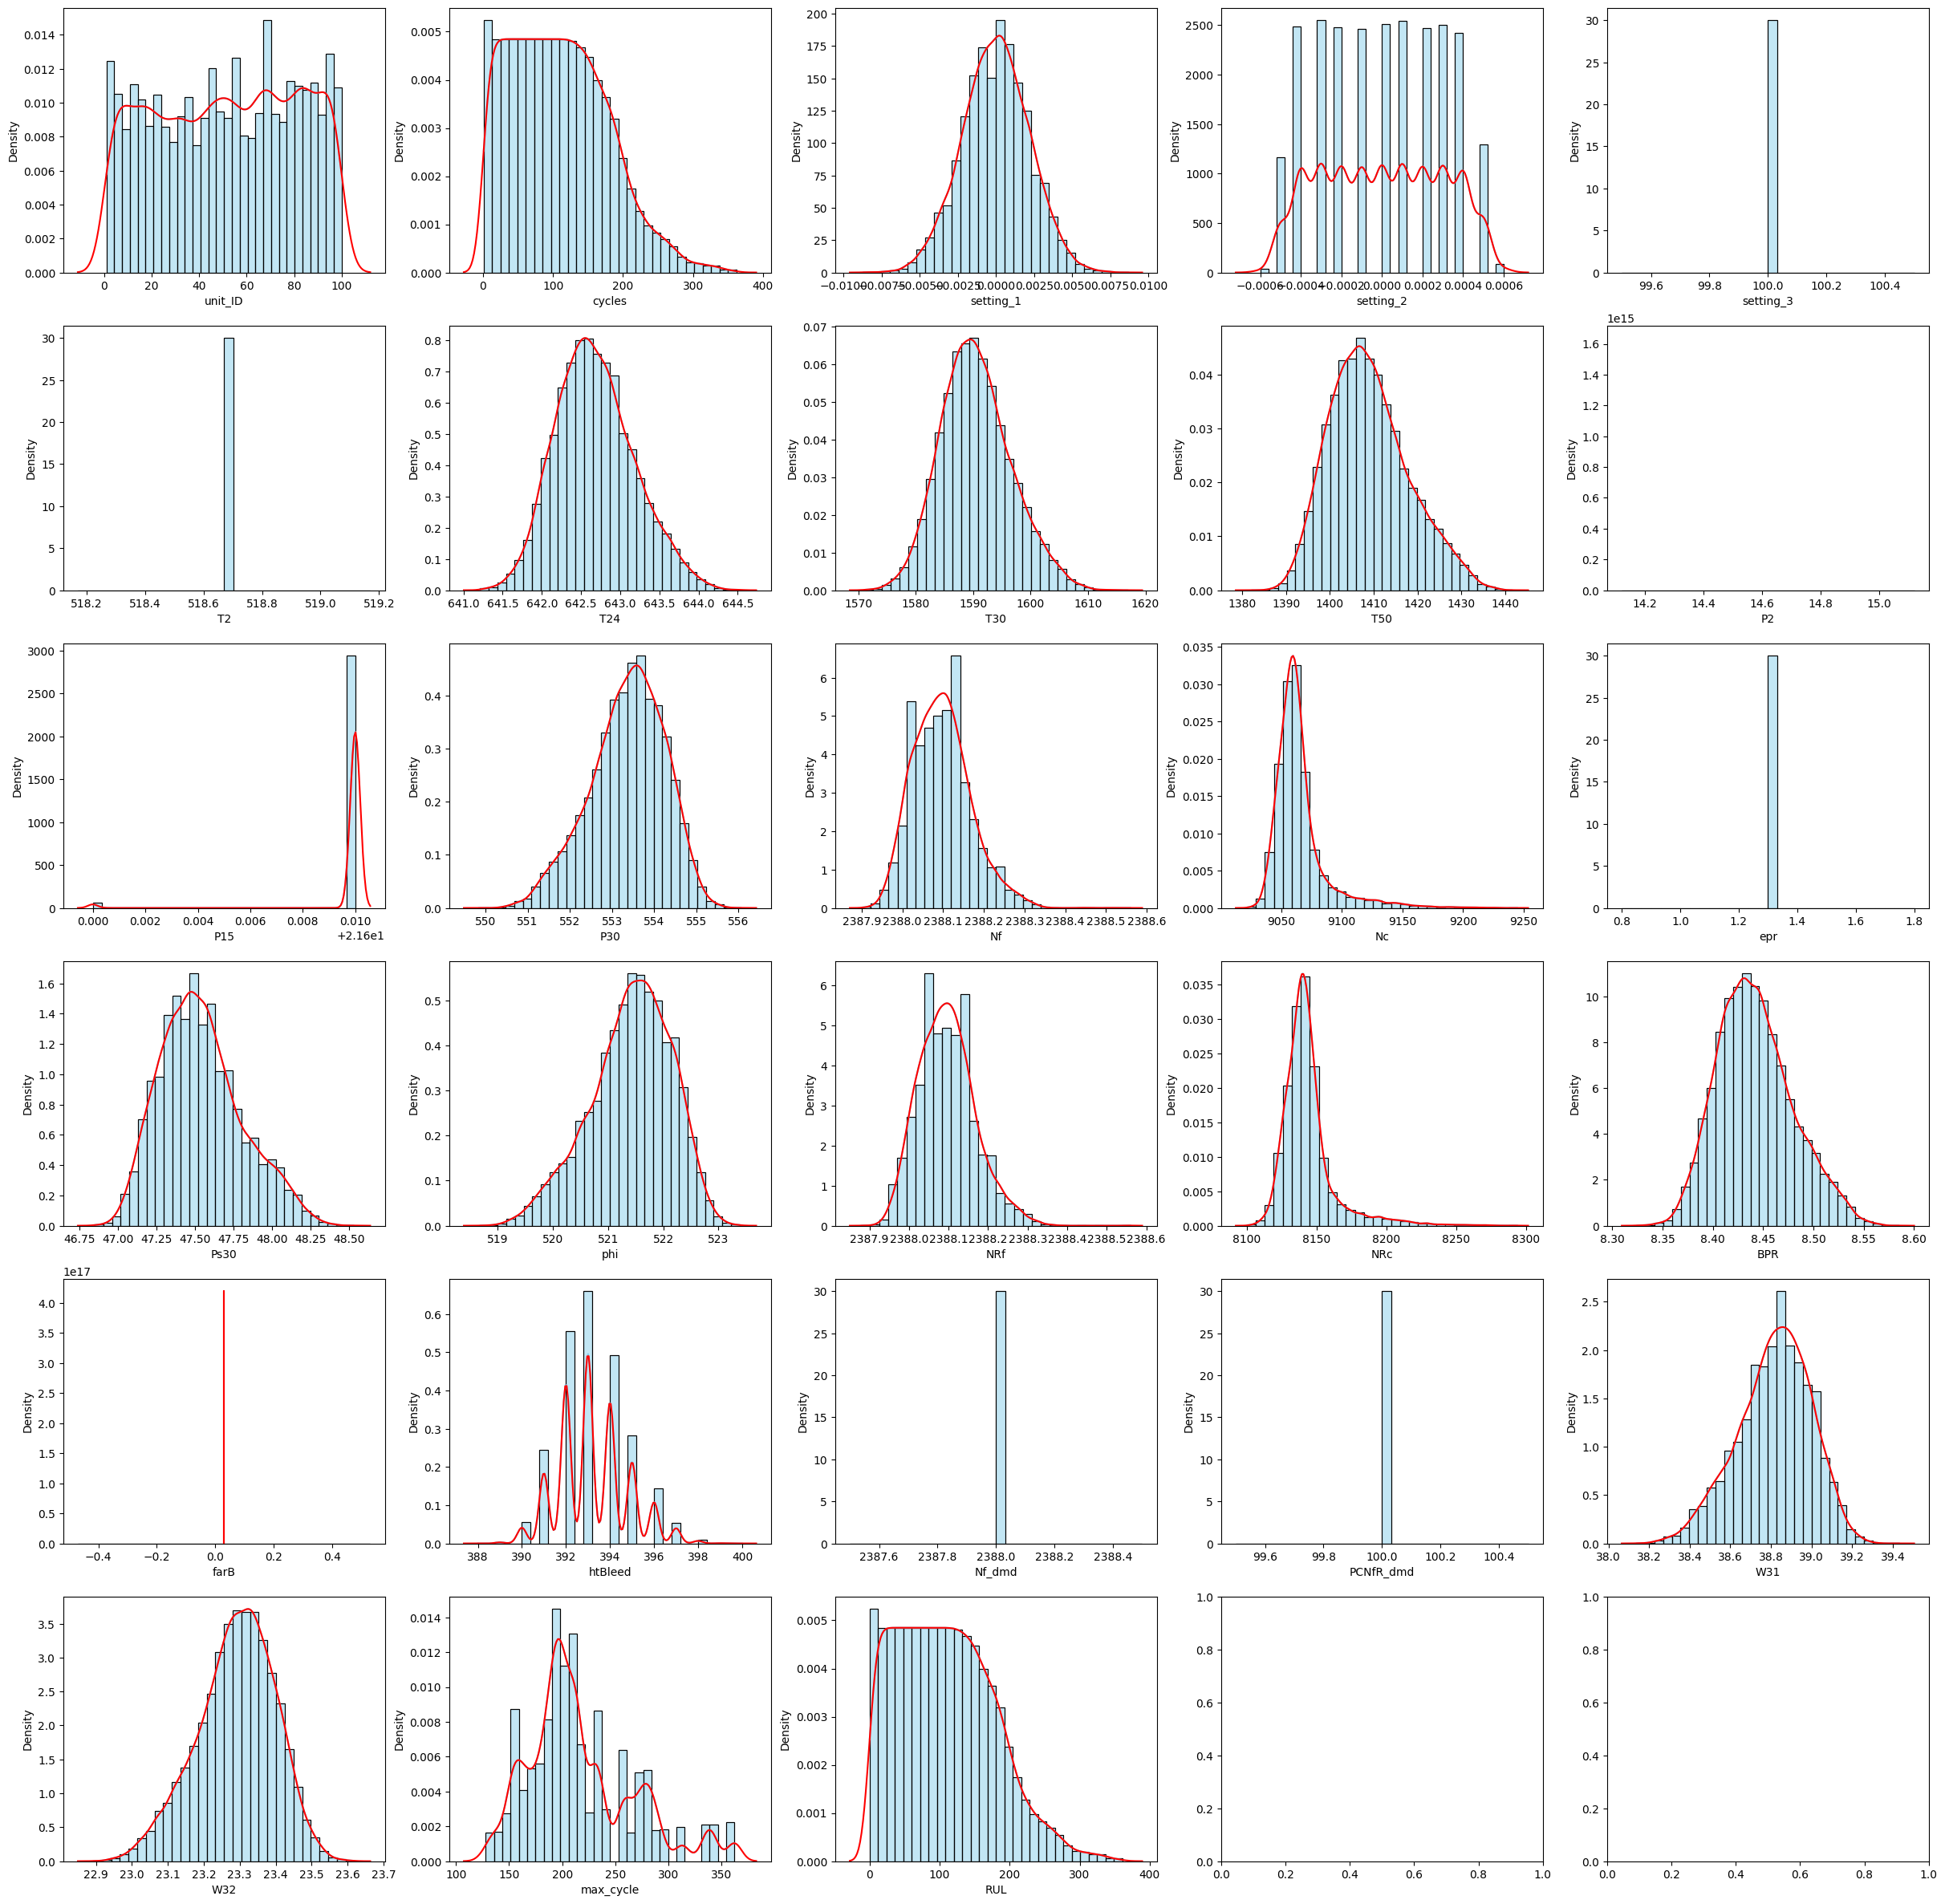

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(6, 5, figsize=(30, 30))
ax = ax.flatten()

for i in range(len(train_df.columns)):
    sns.histplot(
        train_df.iloc[:, i],
        ax=ax[i],
        kde=True,
        bins=30,
        stat="density",
        label="Histogram",
        color="skyblue",
    )
    sns.kdeplot(train_df.iloc[:, i], ax=ax[i], label="KDE", color="red")